In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1

    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol-1, max(0, self.x+change[action][0]))
        self.y = min(self.nrow-1, max(0, self.y+change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False

        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class Sarsa:
    def __init__(self, ncol, nrow, eps, alpha, gamma, n_action=4):
        self.Q_table = np.zeros((ncol*nrow, n_action))
        self.n_action = n_action
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma

    def take_action(self, state):
        if np.random.random() < self.eps:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

In [3]:
class DynaQ(Sarsa):
    def __init__(self, ncol, nrow, eps, alpha, gamma, n_planning, n_action=4):
        super().__init__(ncol, nrow, eps, alpha, gamma, n_action)
        self.n_planning = n_planning
        self.model = dict()

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1
        for _ in range(self.n_planning):
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

Q-planning steps: 0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1999.86it/s, episode=300.0, return=-17.400]


Q-planning steps: 2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1200.08it/s, episode=300.0, return=-13.100]


Q-planning steps: 20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 244.50it/s, episode=300.0, return=-13.600]


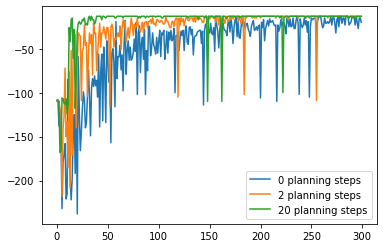

In [5]:
def dynaQ_cliffwalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    # np.random.seed(0)
    eps = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, eps, alpha, gamma, n_planning)
    n_episode = 300

    return_list = []
    for i in range(10):
        with tqdm(total=int(n_episode/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(n_episode/10)):
                episode_return = 0
                state = env.reset()
                action = agent.take_action(state)
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': f'{n_episode/10*i+i_episode+1}', 
                        'return': f'{np.mean(return_list[-10:]):.3f}'})
                pbar.update()
    return return_list


np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print(f'Q-planning steps: {n_planning}')
    time.sleep(0.5)
    return_list = dynaQ_cliffwalking(n_planning)
    episode_list = list(range(len(return_list)))
    plt.plot(episode_list, return_list, label=f'{n_planning} planning steps')
plt.legend()
plt.show()